# Problem Set 6: Unsupervised and Deep Learning

<span style="color:red">Warning!</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

In [352]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
from sklearn.metrics import pairwise_distances_argmin, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l1, l2
import tensorflow as tf
import keras
import random

import warnings
warnings.filterwarnings('ignore')

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful! It my be useful to start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Preprocessing and  Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

First, display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images from your dataset? 

Now, remove all individuals for whom you have fewer than 10 images. How many individuals are you left with in the dataset?

In [353]:
# Your code here
directory = '/Users/jaredschober/Documents/GSPP/Spring_2023/INFO251/PS6/lfw-deepfunneled'
names = os.listdir(directory)
names.remove('.DS_Store') # This seems to be some Mac OS file added to the directory when downloaded
num_images = np.zeros(len(names))
for i in range(len(names)):
    path = '/' + names[i]
    num_images[i] = len(os.listdir(directory+path))
    
names_df = pd.DataFrame({'Names': names, 'Num_images':num_images})
names_df.sort_values(by='Num_images', ascending=False)

,Names,Num_images
4982,George_W_Bush,530.0
3541,Colin_Powell,236.0
1554,Tony_Blair,144.0
3014,Donald_Rumsfeld,121.0
1392,Gerhard_Schroeder,109.0
...,...,...
2243,Paul_Walker,1.0
2241,Ewan_McGregor,1.0
2240,James_Brazelton,1.0
2233,Ed_Book,1.0


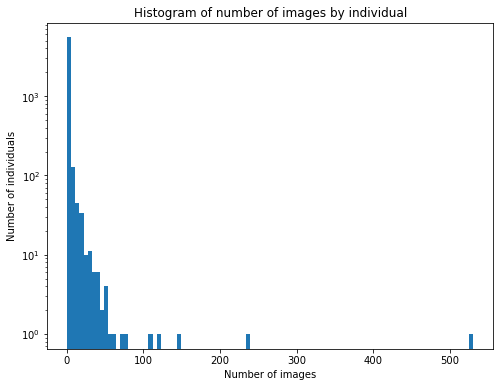

In [354]:
plt.figure(figsize=(8,6))
plt.hist(names_df['Num_images'], bins=100, log=True)
plt.xlabel("Number of images")
plt.ylabel("Number of individuals")
plt.title("Histogram of number of images by individual")
plt.show();

In [355]:
filtered_names_df = names_df[names_df['Num_images']>=10]
filtered_names_df.shape

(158, 2)

*George Bush has the most images in the dataset, with 530. Once we filter out individuals with less than 10 images, we are left with 158 individuals.*

### 1.2. Show some faces!

1. Pick 10 random images from the dataset and display them in a 2 x 5 grid.
2. This time pick 200 random images. Create a single image that shows the "average face" over this random sample -- i.e. each pixel should display the average value of that particular pixel across the random sample. 

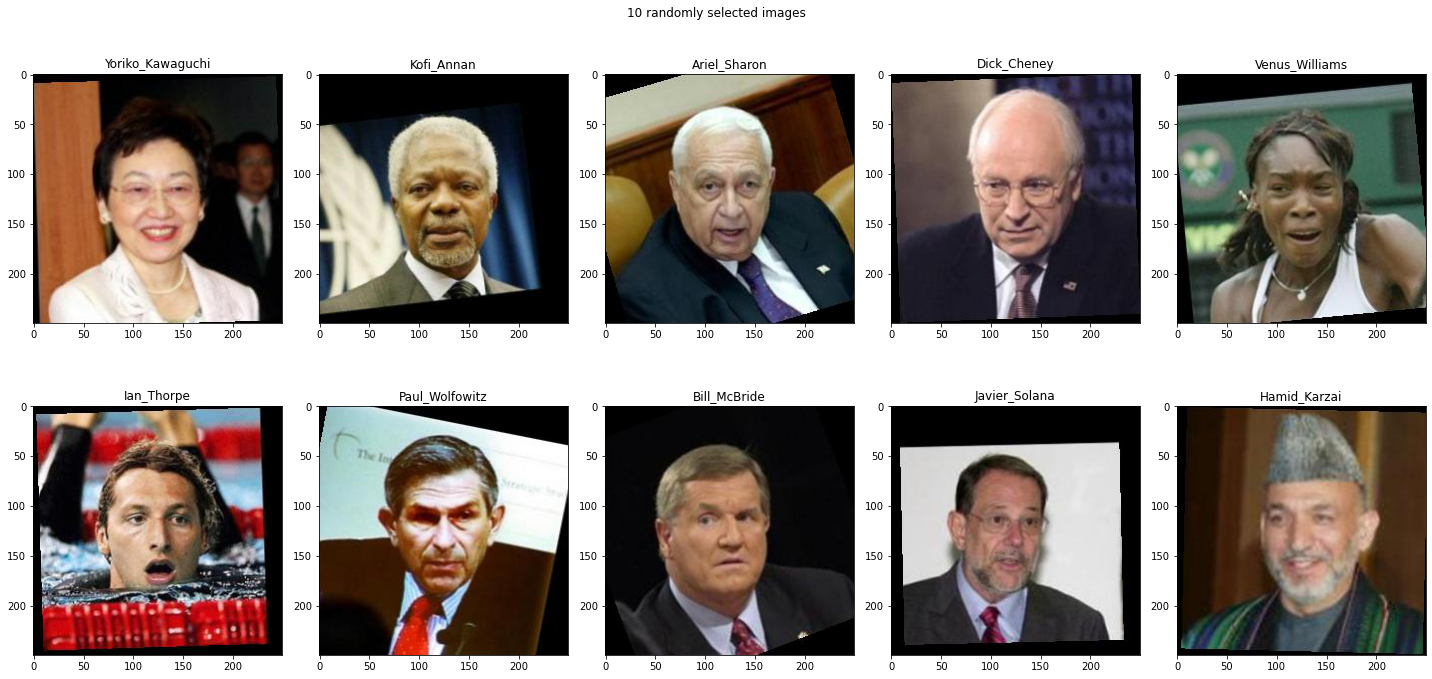

In [356]:
# Your code here
np.random.seed(1443)

# Randomly sampling 10 people, will just display first image for each
sample = filtered_names_df.sample(10)


# Creating figure
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

# Reading in each .jpg image and displaying
for i in range(len(sample)):
    name = sample.iloc[i]['Names']
    path = '/'+ name
    img = io.imread(directory+path+"/"+os.listdir(directory+path)[0])
    ax[i].imshow(img)
    ax[i].set_title(name)
    
fig.suptitle("10 randomly selected images")
fig.tight_layout();

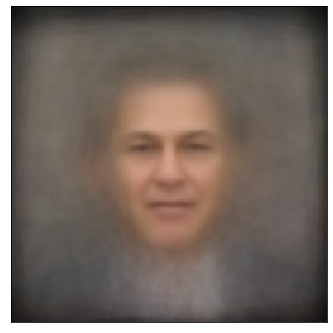

In [357]:
np.random.seed(1443)

# Creating new list of all images
all_images = []
for i in range(len(filtered_names_df)):
#     print(filtered_names_df.iloc[i]['Names'])
    for image in os.listdir(directory+'/'+filtered_names_df.iloc[i]['Names']):
        all_images.append(directory+'/'+filtered_names_df.iloc[i]['Names']+'/'+image)

# Randomly sampling 200 images
random_images = np.random.choice(all_images, size=200)

# Creating collection of images, rather than file paths
selected_images = []
for image in random_images:
    img = io.imread(image)
    selected_images.append(img)

# Calculating average image and then displaying
fig, ax = plt.subplots(1,1,figsize=(5,5))
io.imshow(np.mean(selected_images, axis=0)/255)
ax.set_xticks([])
ax.set_yticks([])
plt.show();

*It seems like the disproportionate number of George Bush samples is biasing the dataset, because even if I remove the random seed, each randomly generated average image still looks a lot like George Bush.*

## 2. k-Means Clustering

### 2.1. Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. Do not use a library like sklearn which provides you built-in k-Means modules. 

*Hint:* You may implement the algorithm using the following steps:
1. initialize the clusters randomly
2. assign each data point to the closest cluster
3. re-estimate cluster centers
4. repeat until assignment doesn't change

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful for step 2.

In [358]:
# Your code here

np.random.seed(1443)

def kmeans(locs, clusters):
    """
    Function
    --------
    K-means
    Implementation of k-means clustering algorithm
    
    Parameters
    ----------
    locs: array
        Array of x, y coordinate data for each observation
    clusters: int
        Number of clusters to classify
    
    Output
    ------
    centroids: array
        Array of x,y centroid locations
    cluster_assignments: array
        Array of cluster assignments for each x,y pair
    """
    
    # Initialize clusters randomly
    print(locs.shape)
    cluster_assignments = np.ones(len(locs))
    for i in range(len(cluster_assignments)):
        cluster_assignments[i] *= np.random.choice(range(clusters))
    df = pd.DataFrame(locs)
    df['clusters'] = cluster_assignments
    # Calculate cluster centroids
    centroids = np.ones(locs.shape) * np.random.choice(np.arange(np.min(locs), np.max(locs)))
    
    while True:
#         # Calculate cluster centroids
        new_centroids = np.ones((clusters,locs.shape[1]))
#         new_centroids = np.ones(locs.shape)
        for i in range(clusters):
            new_centroid = np.mean(df[df['clusters']==i], axis=0)
            new_centroid = new_centroid[new_centroid.keys()!='clusters'].values
            new_centroids[i] = new_centroid
        
        # I was having an error where no locations would be assigned to a cluster
        # In that case, the mean calculated above would result in a Nan value, throwing an error
        # This line replaces Nan values with a random point within the grid
        new_centroids = np.nan_to_num(new_centroids, nan=np.random.choice(np.arange(np.min(locs), np.max(locs))))
        
        # Calculate distance to nearest centroid for each x,y coord
        df['clusters'] = pairwise_distances_argmin(locs, new_centroids)
        
        # If previous centroids are the same as the current ones, break from while loop
        if np.all(centroids == new_centroids):
            break
        else:
            centroids = new_centroids
    
    return centroids, df['clusters'].values

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. Also create a scatterplot that shows these datapoints, colored by cluster. 

(200, 2)


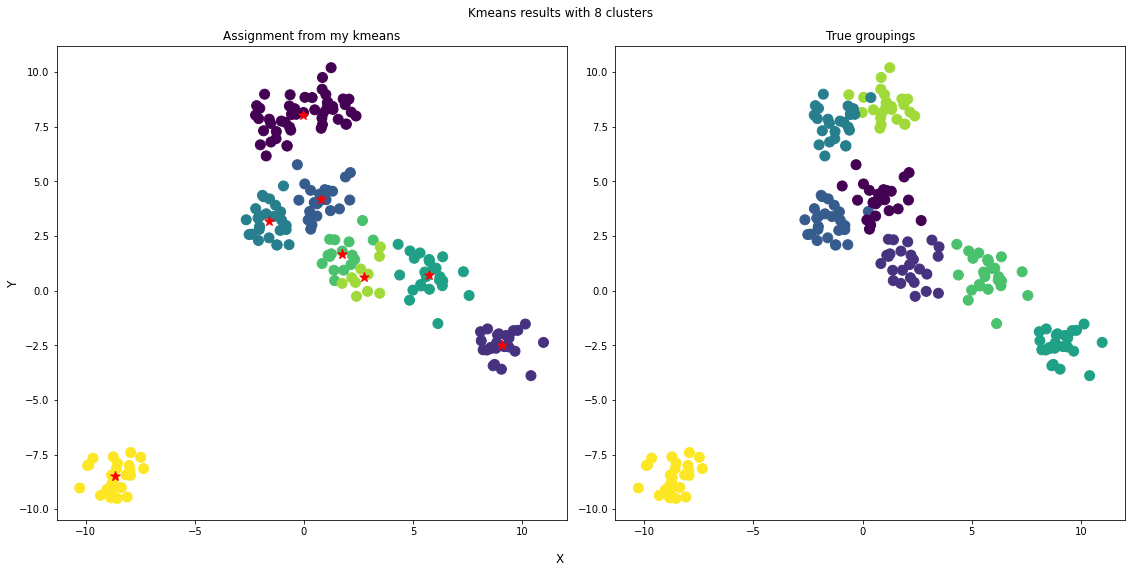

In [359]:
# Your code here
np.random.seed(1443)
from sklearn.datasets import make_blobs
centers=8
locs, clusters = make_blobs(n_samples=200, n_features=2, centers=centers, cluster_std=.75, random_state=0)
centroids, my_clusters= kmeans(locs, centers)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plotting results of my kmeans
ax[0].scatter(locs[:,0], locs[:,1], s=100, c=my_clusters)
ax[0].scatter(centroids[:,0], centroids[:,1], c='r', marker='*', s=100)
ax[0].set_title("Assignment from my kmeans")

# Plotting true results
ax[1].scatter(locs[:,0], locs[:,1], s=100, c=clusters)
ax[1].set_title("True groupings")

fig.suptitle("Kmeans results with {} clusters".format(centers))
fig.supxlabel("X")
fig.supylabel("Y")
plt.tight_layout()
plt.show();

*My algorithm works, but with some error. For instance, for 4 clusters, it slightly misapplies the decision boundary where there is some overlap in the groupings. For higher numbers of clusters, it also gets confused, sometimes splitting groups that aren't split in the true data, and sometimes not splitting groups that are split in the true data. I've displayed 8 clusters above to demonstrate this. However, the algorithm generally works fairly well.*

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=10. 

__Make sure to standardize your data first!__ (You can use sklearn's `Standard Scaler`). You may also want to divide the RGB values by 255.

 Show a 10 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250x250x3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is -- it might take a long time for your algorithm to converge. If your computer is slow, it might even take a very long time for you to simply standardize your data. If your algorithm is slow, we recommend you convert your RGB images into grayscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function, or any other way to convert to graysacle) before standardizing. You may also choose to do this part using RGB images.



In [360]:
# Creating full dataset, rather than just selected images
pictures = pd.DataFrame()
images = []
for image in all_images:
    img = io.imread(image)
    img = skimage.color.rgb2gray(img) # Delete if I want to run with color
    images.append(img)
    
    
X = np.stack(images)
reshaped = X.reshape(4324, 250*250).astype(float) / 255

In [361]:
# This takes a ton of time to run - may need to grayscale
scaler = StandardScaler()
norm = scaler.fit_transform(reshaped)
norm

array([[-0.29776874, -0.31162047, -0.32063266, ..., -0.37255028,
        -0.35363194, -0.33951074],
       [-0.19923555, -0.21690467, -0.22843577, ..., -0.1306213 ,
        -0.07995527, -0.05528185],
       [ 0.91836394,  0.83529041,  0.77736162, ...,  2.9033449 ,
         3.09624605,  3.21851156],
       ...,
       [ 0.20080056,  0.18973924,  0.19046339, ...,  1.88855875,
         2.37560008,  2.81660889],
       [-0.1332478 , -0.13765873, -0.08972083, ...,  1.64607292,
         1.810495  ,  1.91698106],
       [-0.29956022, -0.32424747, -0.30977243, ..., -0.37255028,
        -0.34854256, -0.33422513]])

In [362]:
normalized_images = norm

In [363]:
normalized_images = np.stack(normalized_images)
normalized_images.shape

(4324, 62500)

In [364]:
centroids, my_clusters= kmeans(normalized_images, 10)

(4324, 62500)


In [365]:
unnormalized_centroids = scaler.inverse_transform(centroids).reshape(10,250,250)

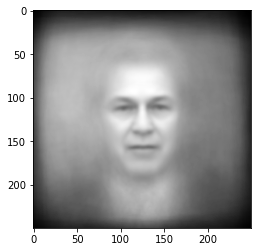

In [366]:
# Test on the first image - can delete
plt.imshow(scaler.inverse_transform(centroids[0].reshape(1,-1)).reshape(250,250), cmap=plt.cm.gray)

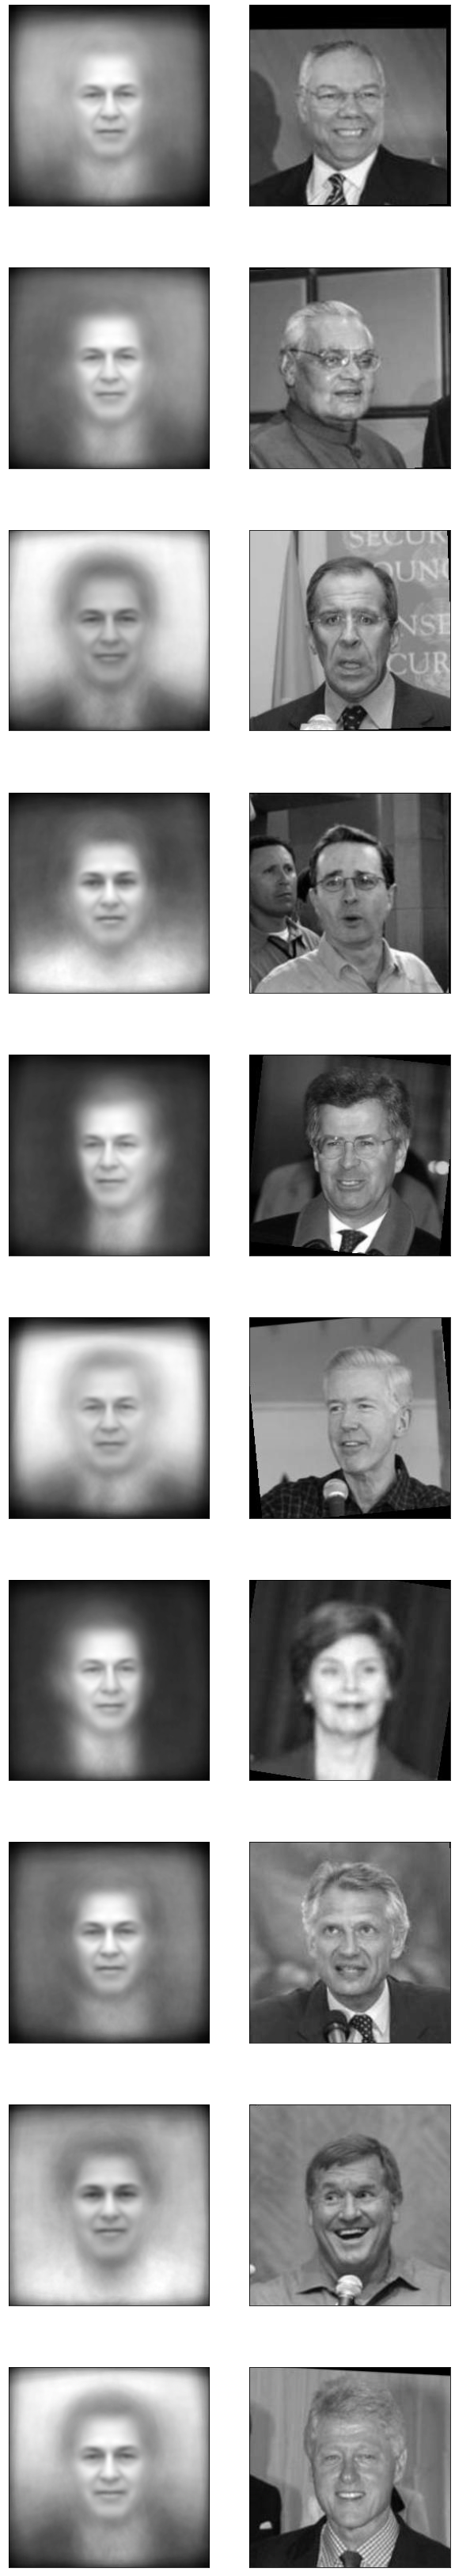

In [367]:
indices = pairwise_distances_argmin(centroids, test)
indices

fig, ax = plt.subplots(10,2, figsize=(10,60))
for i in range(len(indices)):
    
    # Centroids go here
    
    ax[i][0].imshow(unnormalized_centroids[i].reshape(250,250), cmap=plt.cm.gray)
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    ax[i][1].imshow(X[indices[i]], cmap=plt.cm.gray)
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])

*These results are very interesting - the centroids all look somewhat similar to each other and similar to the result from question 1. Overall, the centroids look like a slightly adjusted George Bush over and over, even when it claims the closest image is someone who isn't a white man. As we saw from question 1, George Bush has over 500 photos in this dataset, which is more than twice the next most represented person, Colin Powell. It seems that the overrepresentation of one person in our sample is biasing the centroid outputs quite a bit (in fact, if you squint, the centroids sort of look like an amalgamation of Bush and Powell).*

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself.
 2. The cluster centroid closest to that image.
 3. The closest image in the dataset to that cluster centroid.
 4. The closest image in the dataset to the image of yourself.


In [368]:
path = './myimage.jpg'
my_img = io.imread(path)
my_img = skimage.transform.resize(my_img, (250,250,3), anti_aliasing=True)
my_img = skimage.color.rgb2gray(my_img)

In [369]:
closest_centroid_index = pairwise_distances_argmin(my_img.reshape(1,(250*250)), centroids)

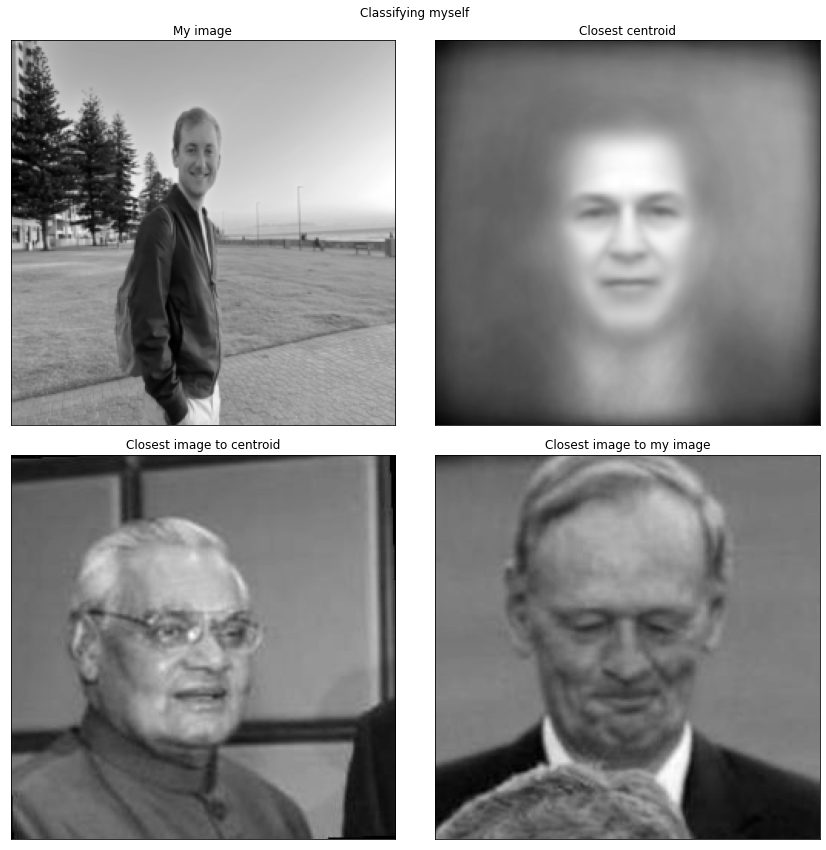

In [370]:
#Reading in my image and converting to grayscale
path = './myimage.jpg'
my_img = io.imread(path)
my_img = skimage.transform.resize(my_img, (250,250,3), anti_aliasing=True)
my_img = skimage.color.rgb2gray(my_img)

# Calculating closest centroid to my image
closest_centroid_index = pairwise_distances_argmin(my_img.reshape(1,(250*250)), centroids)

fig, ax = plt.subplots(2,2,figsize=(12,12))

# Displaying my image
ax[0][0].imshow(my_img, cmap=plt.cm.gray)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_title("My image")

# Displaying closest centroid
ax[0][1].imshow(scaler.inverse_transform(centroids[closest_centroid_index]).reshape(250,250), cmap=plt.cm.gray)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])
ax[0][1].set_title("Closest centroid")

# Calculating image closest to centroid and then displaying
closest_image_to_centroid = pairwise_distances_argmin(centroids[closest_centroid_index], test)
ax[1][0].imshow(X[closest_image_to_centroid].reshape(250,250), cmap=plt.cm.gray)
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_title("Closest image to centroid")

# Calculating image closest to my image and then displaying
closest_image_to_myimg = pairwise_distances_argmin(my_img.reshape(1,250*250), test)
ax[1][1].imshow(X[closest_image_to_myimg].reshape(250,250), cmap=plt.cm.gray)
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])
ax[1][1].set_title("Closest image to my image")

fig.suptitle("Classifying myself")
plt.tight_layout();
plt.show();

*All things considered, I think it classified me somewhat well. The clustering algorithm has caught on to the fact that I'm a white man, although the centroid and closest images are much older than I am. Once again, I think this demonstrates the bias in the data. Since so many of our images are of early 2000's era American politicians, the dataset is very skewed toward older, white men.*

# 3. Deep Learning

*Note:* You may use either `keras` or `PyTorch` to define your neural networks.

### 3.1 Data preprocessing
1. For this problem, filter to images associated with people that have at least 100 images in the dataset. Use the color version of the images (not grayscale). We'll use this dataset for a supervised multiclass classification problem, classifying which person each image is. How many classes (people) are there? How many observations (images) are there total?

2. Divide the reduced dataset into 50% train and 50% test. Standardize the data.

In [371]:
# Your code here

images_nn = []
labels = []
filtered_names_df_nn = names_df[names_df['Num_images']>=100]


for i in range(len(filtered_names_df_nn)):
    for image in os.listdir(directory+'/'+filtered_names_df_nn.iloc[i]['Names']):
        path = directory+'/'+filtered_names_df_nn.iloc[i]['Names']+'/'+image
        img = io.imread(path)
        images_nn.append(img)
        labels.append(filtered_names_df_nn.iloc[i]['Names']) # adding labels

In [372]:
nn_df = pd.DataFrame({'labels': labels, 'images_nn': images_nn})

In [373]:
nn_df['labels'].value_counts()

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Name: labels, dtype: int64

In [374]:
nn_df.shape

(1140, 2)

In [375]:
X_train, X_test, y_train, y_test = train_test_split(nn_df['images_nn'],nn_df['labels'], test_size=0.5, random_state=0)

In [376]:
# Normalizing the data
scaler = StandardScaler()
normalized_images_train = scaler.fit_transform(np.stack(X_train).reshape(570, 250*250*3).astype(float) / 255)
normalized_images_test = scaler.transform(np.stack(X_test).reshape(570, 250*250*3).astype(float) / 255)

*There are 1140 images across 5 classes (George W Bush, Colin Powell, Tony Blair, Donald Rumsfeld, and Gerhard Schroeder).*

### 3.2 Naive baseline
As a naive baseline method to compare to, create a random ordering of the labels in the training set and the test set. Report the overall classification accuracy for the shuffled labels in comparison to the true labels. Also report the true positive rate for each class. This random baseline represents a naive classifier that guesses randomly among the classes. What do you notice about the differences in precision and recall across classes?

In [377]:
y_train = y_train.to_frame()

In [378]:
y_test = y_test.to_frame()

In [379]:
# shuffling indices
np.random.seed(1)
shuffled_labels = y_train.copy().sample(frac=1).values
y_train['shuffled_labels'] = shuffled_labels 

shuffled_labels_test = y_test.copy().sample(frac=1).values
y_test['shuffled_labels'] = shuffled_labels_test

In [380]:
y_train['Accuracy'] = y_train.apply(lambda x: x.labels in x.shuffled_labels, axis=1).astype(int)
y_test['Accuracy'] = y_test.apply(lambda x: x.labels in x.shuffled_labels, axis=1).astype(int)

In [381]:
y_train

,labels,shuffled_labels,Accuracy
966,George_W_Bush,George_W_Bush,1
832,George_W_Bush,George_W_Bush,1
109,Tony_Blair,Colin_Powell,0
379,Colin_Powell,George_W_Bush,0
171,Tony_Blair,Colin_Powell,0
...,...,...,...
1033,George_W_Bush,Donald_Rumsfeld,0
763,George_W_Bush,Colin_Powell,0
835,George_W_Bush,George_W_Bush,1
559,Colin_Powell,George_W_Bush,0


In [382]:
y_test

,labels,shuffled_labels,Accuracy
1014,George_W_Bush,Colin_Powell,0
878,George_W_Bush,George_W_Bush,1
1070,George_W_Bush,George_W_Bush,1
184,Tony_Blair,Tony_Blair,1
685,George_W_Bush,Colin_Powell,0
...,...,...,...
250,Tony_Blair,George_W_Bush,0
243,Tony_Blair,Tony_Blair,1
942,George_W_Bush,Colin_Powell,0
35,Gerhard_Schroeder,George_W_Bush,0


In [383]:
# Overall classification accuracy
print('Accuracy score on training set: %.2f' % \
      accuracy_score(y_true=y_train['labels'], y_pred=y_train['shuffled_labels']))

print('Accuracy score on test set: %.2f' % \
      accuracy_score(y_true=y_test['labels'], y_pred=y_test['shuffled_labels']))


Accuracy score on training set: 0.30
Accuracy score on test set: 0.31


In [384]:
# True positive rate by class for train set
y_train.groupby('labels')['Accuracy'].sum() / y_train.groupby('labels')['Accuracy'].count()

labels
Colin_Powell         0.226891
Donald_Rumsfeld      0.086207
George_W_Bush        0.460674
Gerhard_Schroeder    0.076923
Tony_Blair           0.162162
Name: Accuracy, dtype: float64

In [385]:
# True positive rate by class for test set
y_test.groupby('labels')['Accuracy'].sum() / y_test.groupby('labels')['Accuracy'].count()

labels
Colin_Powell         0.205128
Donald_Rumsfeld      0.158730
George_W_Bush        0.471483
Gerhard_Schroeder    0.122807
Tony_Blair           0.185714
Name: Accuracy, dtype: float64

In [386]:
# Precision
print('Precision score on training set: %.2f' % \
     precision_score(y_true=y_train['labels'], \
                y_pred=y_train['shuffled_labels'], \
                average='macro'))

print('Precision score on training set: %.2f' % \
     precision_score(y_true=y_test['labels'], \
                y_pred=y_test['shuffled_labels'], \
                average='macro'))

Precision score on training set: 0.20
Precision score on training set: 0.23


In [387]:
# Precision
print(precision_score(y_true=y_train['labels'], y_pred=y_train['shuffled_labels'], average=None))
print(precision_score(y_true=y_test['labels'], y_pred=y_test['shuffled_labels'], average=None))

[0.22689076 0.0862069  0.46067416 0.07692308 0.16216216]
[0.20512821 0.15873016 0.47148289 0.12280702 0.18571429]


In [388]:
# Recall
print(recall_score(y_true=y_train['labels'], y_pred=y_train['shuffled_labels'], average=None))
print(recall_score(y_true=y_test['labels'], y_pred=y_test['shuffled_labels'], average=None))

[0.22689076 0.0862069  0.46067416 0.07692308 0.16216216]
[0.20512821 0.15873016 0.47148289 0.12280702 0.18571429]


The naive baseline accuracy is 0.30 for the train set, and 0.32 for the test set.

*The precision and recall scores are higher for classes that have more observations (e.g. George Bush) and lower for classes with fewer observations. This is a reflection of how unbalanced the data is - it's easier to randomly guess George Bush correctly if there are far more instances of George Bush in the data set compared to other classes.*

### 3.3 Feed forward neural network
Reshape your X data so that each observation is flattened into a 1d array, and each of the training and test matrices are 2d arrays. The shape of your data should be n_observations X 187,500. Train a fully connected neural network to predict which class each observation is in. The input_dimensions of your network will be 187,500 for each of the 187,500 "features" obtained from the flattened images. You are responsible for determining the structure of the network, the activiation functions, regularization, and optmization techniques. Ensure that your network exceeds 70% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the naive baseline?

*Hint: If you're not sure where to start, consider revisiting the lab notebooks on Neural Networks.*

In [389]:
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# One hot encode the y-values
y_train_dummies = pd.get_dummies(y_train['labels'].values)
y_test_dummies = pd.get_dummies(y_test['labels'].values)

# Define NN
model = Sequential()
model.add(Dense(10, input_dim=normalized_images_train.shape[1], activation='relu'))
model.add(Dense(len(y_train_dummies.columns), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Fit and predict with NN
model.fit(normalized_images_train, y_train_dummies.values, epochs=100, batch_size=10, verbose=0)
yhat_train = model.predict(normalized_images_train)
yhat_test = model.predict(normalized_images_test)

18/18 [==============================] - 1s 10ms/step


In [390]:
yhat_train = model.predict(normalized_images_train)
yhat_test = model.predict(normalized_images_test)

18/18 [==============================] - 0s 10ms/step


In [391]:
# Get metrics
print('Accuracy on training set: %.2f' % accuracy_score(y_train_dummies.values, np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0)))
print('Accuracy on test set: %.2f' % accuracy_score(y_test_dummies.values, np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0)))

Accuracy on training set: 0.92
Accuracy on test set: 0.74


In [392]:
# Precision
print(precision_score(y_true=y_train_dummies.values, \
                      y_pred=np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

print(precision_score(y_true=y_test_dummies.values, \
                      y_pred=np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

[0.99145299 1.         0.8585209  0.95555556 1.        ]
[0.7704918  0.73469388 0.75961538 0.60606061 0.62962963]


In [393]:
# Recall
print(recall_score(y_true=y_train_dummies.values, \
                      y_pred=np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

print(recall_score(y_true=y_test_dummies.values, \
                      y_pred=np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

[0.97478992 0.82758621 1.         0.82692308 0.66216216]
[0.8034188  0.57142857 0.90114068 0.35087719 0.48571429]


*The accuracy has increased greatly from the naive baseline to 74% accuracy on the test set. Similarly, the precision and recall scores have increased quite a bit, with precision averaging around 70%+ on the test set, and recall averaging ~60%+. There is much more variance in the test recall, and some classes still have somewhat low scores (35% or 48.5%), while one has a recall score of over 90%.*

### 3.4 Convolutional neural network

Now, train a convolutional neural network to predict which person is in each image. As above, you are in charge of all design parameters for the network, including convolutional filters, pooling layers, regularization, and optimization. Ensure that your CNN achieves over 80% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the feed forward neural network and naive baseline?

*Hint: If you're not sure where to start, consider revisiting the lab notebooks on Neural Networks.*

In [394]:
# Your code here

np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

input_shape = normalized_images_train.reshape(570, 250, 250, 3).shape[1:]

model = Sequential()
model.add(Conv2D(filters=1, kernel_size=(3, 3), strides=1, activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=1, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(Conv2D(filters=1, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2))
model.add(Conv2D(filters=1, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(Conv2D(filters=1, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.1))) # Adding fully connected layer
model.add(Dense(5, activation='softmax')) # Sigmoid better than softmax for multiclass classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [395]:
model.fit(normalized_images_train.reshape(570, 250, 250, 3), \
          y_train_dummies.values, \
          epochs=100, \
          batch_size=30, \
          verbose=0)

yhat_train = model.predict(normalized_images_train.reshape(570, 250, 250, 3))
yhat_test = model.predict(normalized_images_test.reshape(570, 250, 250, 3))

18/18 [==============================] - 4s 178ms/step


In [396]:
print('Accuracy score on training set: %.2f' % \
      accuracy_score(y_train_dummies.values, np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0)))
print('Accuracy score on test set: %.2f' % \
      accuracy_score(y_test_dummies.values, np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0)))

Accuracy score on training set: 1.00
Accuracy score on test set: 0.90


In [397]:
print('AUC score on training set: %.2f' % \
      roc_auc_score(y_train_dummies.values, np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0)))
print('AUC score on test set: %.2f' % \
      roc_auc_score(y_test_dummies.values, np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0)))

AUC score on training set: 1.00
AUC score on test set: 0.93


In [398]:
# Precision
print(precision_score(y_true=y_train_dummies.values, \
                      y_pred=np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

print(precision_score(y_true=y_test_dummies.values, \
                      y_pred=np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

[1. 1. 1. 1. 1.]
[0.8968254  0.93220339 0.94071146 0.75       0.84210526]


In [399]:
# Recall
print(recall_score(y_true=y_train_dummies.values, \
                      y_pred=np.where(yhat_train == yhat_train.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

print(recall_score(y_true=y_test_dummies.values, \
                      y_pred=np.where(yhat_test == yhat_test.max(axis=1).reshape(-1, 1), 1, 0), \
                      average=None))

[1. 1. 1. 1. 1.]
[0.96581197 0.87301587 0.90494297 0.73684211 0.91428571]


*I based this CNN on AlexNet and VGG, and included two convolutional blocks with pooling at the end of each block. I found that adding the second block improved the accuracy, but adding an additional block greatly reduced accuracy. I got an overall test accuracy of 90%, with precision and recall scores that range from ~75% to 96.5%. It seems like the George Bush class still has the highest precison and recall scores, but the scores overall increased significantly over the feed-forward neural network (not to mention the naive baseline).*